## D-Wave Utilities Package Overview
### Nic Ezzell

* We'll focus on features, but helpful to be aware of a few "implementation details"
    1. Uses python 3.x and connects with D-Wave via Ocean
    2. All manipulations center around DictRep class

In [1]:
# Handle the relevant import statements before moving on...
import sys
sys.path.append("../dwaveutils/dwavetools")
sys.path.append("../dwaveutils/probrep")
from dictrep import DictRep
from dwavetools import (find_heff_s, make_dwave_schedule, create_heff_csv,
                        nqubit_1pauli, nqubit_2pauli, loadAandB,
                        make_numeric_schedule, time_interpolation,
                        get_numeric_H)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import qutip as qt

### Creating and Visualize a "Logical" Hamiltonian

In [8]:
H1 = {(0, 0): 0.1, (1, 1): 0.1, (2, 2): 0.1, (0, 1): -0.1, (1, 2): -0.1, (0, 2): 0.1}
problem1 = DictRep(H = H1, qpu = 'dwave', vartype = 'ising', encoding = 'logical')

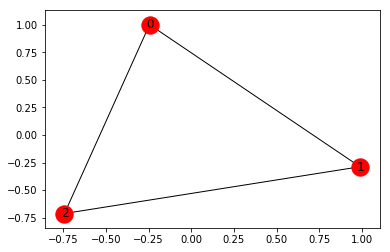

In [21]:
fig = plt.figure()
graph = problem1.visualize_graph()
plt.savefig("3qubit_problem.png")

### Submit the Problem to D-Wave and Post-process Response

In [10]:
response1 = problem1.call_annealer() # this is the default OCEAN response
totaloutput = []
for energy, state, n in response1.data(['energy', 'sample', 'num_occurrences']):
    nthdata = [energy, state, n]
    totaloutput.append(nthdata)
print(totaloutput[0])
print(totaloutput[-1])
print(len(totaloutput))

[-0.4, {0: -1, 1: -1, 2: -1}, 1]
[0.20000000000000004, {0: -1, 1: 1, 2: -1}, 1]
246


### Trying Same Problem with "Direct" Encoding

In [13]:
H2 = {(0, 0): 0.1, (1, 1): 0.1, (2, 2): 0.1, (0, 1): -0.1, (1, 2): -0.1, (0, 2): 0.1}
problem2 = DictRep(H = H2, qpu = 'dwave', vartype = 'ising', encoding = 'direct')
try:
    response2 = problem2.call_annealer()
except:
    print("No three qubits are connected on Chimera with desired graph Topology.")

No three qubits are connected on Chimera with desired graph Topology.


### Now let's do a parameter swep when our problem has 'variable' weights

In [24]:
H3 = {(0, 0): 'h0', (1, 1): 'h0', (2, 2): 'h0', (0, 1): 'J1', (1, 2): 'J1', (0, 2): 'J2'}
problem3 = DictRep(H3, 'dwave', 'ising', 'logical')

# Set values for abstract parameters to take
h0 = np.linspace(0, 0.1, 2)
J1 = [-.1]
J2 = np.linspace(0, 0.1, 2)

# Create anneal schedules to try
sch1 = make_dwave_schedule('forward', s = 1, ta = 20)
sch2 = make_dwave_schedule('forward', s = 0.5, ta = 10, tp = 5, tq = 5)

#propogate these parameters to problem3
parameters = {'h0': h0, 'J1': J1, 'J2': J2, 'anneal_schedule': [sch1, sch2], 'num_reads': [1]}
problem3.populate_parameters(parameters)
data = problem3.call_annealer(cull = False)
data.head()

,J1,J2,anneal_schedule,energy,h0,num_reads,state
0,-0.1,0.0,"[[0, 0], [20, 1]]",-0.2,0.0,1.0,"(-1, -1, -1)"
1,-0.1,0.0,"[[0, 0], [20, 1]]",-0.2,0.0,1.0,"(-1, -1, -1)"
2,-0.1,0.0,"[[0, 0], [20, 1]]",-0.2,0.0,1.0,"(-1, -1, -1)"
3,-0.1,0.0,"[[0, 0], [20, 1]]",-0.2,0.0,1.0,"(-1, -1, -1)"
4,-0.1,0.0,"[[0, 0], [20, 1]]",-0.2,0.0,1.0,"(-1, -1, -1)"


### Class allows common post-processing routines to become trivial...

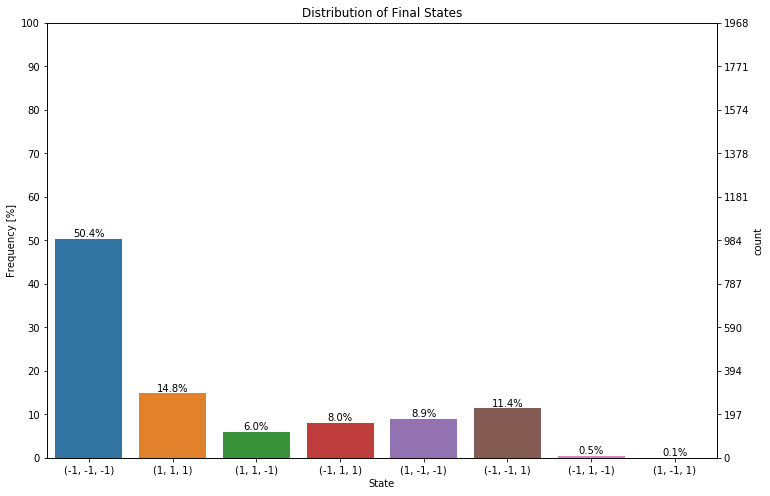

In [26]:
problem3.save_data('test.csv')
state_plot = problem3.get_state_plot(figsize = (12, 8), filename = 'test.png')

### Utilizing Transverse-field Shows Real Power

In [2]:
transH = {(0, 0): 'h', (1, 1): 'h', (2, 2): 'h', (0, 1): 'J1', (1, 2): 'J1', (0, 2): 'J2'}
problem4 = DictRep(transH, 'dwave', 'ising', 'logical')
# load in chip data (simplified csv file created with dwavetools)
heff_to_s = pd.read_csv("../dwaveutils/probrep/heff_to_s_DW_2000Q_2_June2018.csv")

#set h/ J vals
h = [0]
J1 = [-.1]
J2 = np.linspace(-0.4, 0.4, 2)
#set hxvals, find corresponding svals
hxvals = np.linspace(0, 0.4, 2)
hidxs = pd.Index(heff_to_s['heff'])
csv_svals = pd.Index(heff_to_s['s'])
s_to_hx = {}
svals = []
for hx in hxvals:
    s = csv_svals[hidxs.get_loc(hx, 'nearest')]
    svals.append(s)
    s_to_hx[s] = hx
    
#create anneal_schedules that correspond to quenching at s when heff = hx with various anneal lengths
atimes = [100]
schedules = [make_dwave_schedule('f', s, ta, 0, 1-s) for s in svals for ta in atimes]

In [3]:
parameters4 = {'h': h, 'J1': J1, 'J2': J2, 'anneal_schedule': schedules, 'num_reads': [1]}
problem4.populate_parameters(parameters4)
data4 = problem4.call_annealer(cull = False, s_to_hx=s_to_hx)
print(data4.tail())
problem4.save_data("dwave_trans.csv")

      J1   J2                     anneal_schedule  energy    h   hx  \
979 -0.1  0.4  [[0, 0], [100, 0.44], [100.56, 1]]    -0.4  0.0  0.4   
980 -0.1  0.4  [[0, 0], [100, 0.44], [100.56, 1]]    -0.4  0.0  0.4   
981 -0.1  0.4  [[0, 0], [100, 0.44], [100.56, 1]]    -0.4  0.0  0.4   
982 -0.1  0.4  [[0, 0], [100, 0.44], [100.56, 1]]     0.2  0.0  0.4   
983 -0.1  0.4  [[0, 0], [100, 0.44], [100.56, 1]]     0.2  0.0  0.4   

     num_reads         state  
979        1.0    (-1, 1, 1)  
980        1.0   (-1, -1, 1)  
981        1.0    (1, 1, -1)  
982        1.0     (1, 1, 1)  
983        1.0  (-1, -1, -1)  


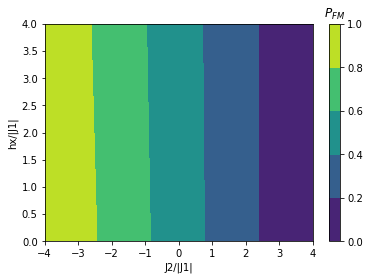

In [4]:
plt = problem4.get_ferro_diagram('J2', 'hx', 'J1')
plt.savefig("dwave_trans_contour.eps", dpi=300)

### Creating and Saving Custom Embedding (Chaining)

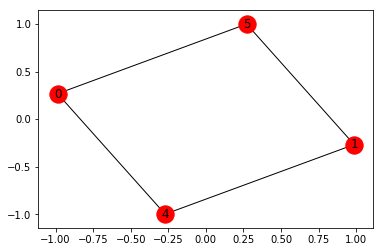

In [5]:
Hembedding = {(0, 0): 'h', (4, 4): 'h', (1, 1): 'h/2', (5, 5): 'h/2', (0, 4): 'J2',
             (0, 5): 'J1', (1, 4): 'J1', (1, 5): 'J3'}
emproblem = DictRep(H = Hembedding, qpu = 'dwave', vartype = 'ising', encoding = 'direct')
emproblem.visualize_graph()
emproblem.save_config('square_embedding')

In [6]:
# Set values for abstract parameters to take
h = np.linspace(0, 0.1, 2)
J1 = [-.1]
J2 = np.linspace(0, 0.1, 2)
J3 = [-1]

# Create anneal schedules to try
sch1 = make_dwave_schedule('forward', s = 1, ta = 20)

#propogate these parameters to problem3
parameters = {'h': h, 'J1': J1, 'J2': J2, 'J3': J3, 'anneal_schedule': [sch1], 'num_reads': [1]}
emproblem.populate_parameters(parameters)
data = emproblem.call_annealer(cull = False)
data.head()

,J1,J2,J3,anneal_schedule,energy,h,num_reads,state
0,-0.1,0.0,-1.0,"[[0, 0], [20, 1]]",-1.2,0.0,1.0,"(-1, -1, -1, -1)"
1,-0.1,0.1,-1.0,"[[0, 0], [20, 1]]",-1.1,0.0,1.0,"(-1, -1, 1, -1)"
2,-0.1,0.0,-1.0,"[[0, 0], [20, 1]]",-1.5,0.1,1.0,"(-1, -1, -1, -1)"
3,-0.1,0.1,-1.0,"[[0, 0], [20, 1]]",-1.4,0.1,1.0,"(-1, -1, -1, -1)"


### QuTip Exact Diagonlization and Numerical Simulation

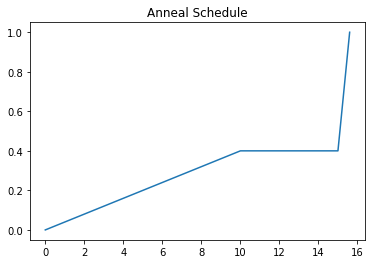

In [6]:
# Form a dictionary representation of a problem and create an anneal_schedule
dictparams = {(0, 0): 0.1, (1, 1): 0.1, (2, 2): 0.1, (0, 1): -0.1, (1, 2): -0.1, (0, 2): -0.1}
problem = DictRep(H = dictparams, qpu = 'dwave', vartype = 'ising', encoding = "logical")
ta, sa, tp, tq = 10, 0.4, 5, 0.6
T = ta + tp + tq
schedule = make_numeric_schedule(.1, **{'ta': ta, 'sa': sa, 'tp': tp, 'tq': tq})
times = schedule[0]
svals = schedule[1]

plt.plot(times, svals)
plt.title("Anneal Schedule")
plt.show()

In [7]:
# Create H(t)
processor_data = loadAandB()
sch_ABfuncs = time_interpolation(schedule, processor_data)
A, B = sch_ABfuncs['A(t)'], sch_ABfuncs['B(t)']
Hs = get_numeric_H(problem)
HX, HZ = Hs['HX'], Hs['HZ']

# Define H(t)
H = lambda t : A(t)*HX + B(t)*HZ

# Define list_H for QuTiP
list_H = [[HX, A], [HZ, B]]

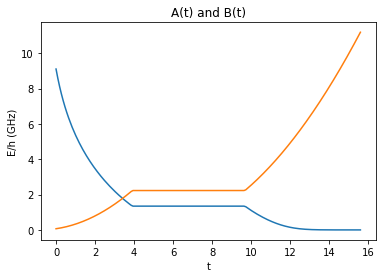

In [8]:
plt.plot(times, A(times))
plt.plot(times, B(times))
plt.title("A(t) and B(t)")
plt.ylabel('E/h (GHz)')
plt.xlabel('t')
plt.show()

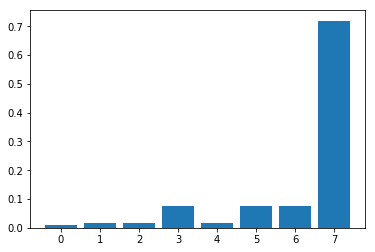

In [22]:
# exact diagonlization of ground-state at the end
gs = H(T).groundstate()[1]
gs_amps = np.array([abs(gs[i])**2 for i in range(8)])
plt.bar([0, 1, 2, 3, 4, 5, 6, 7], gs_amps.flatten())
plt.show()

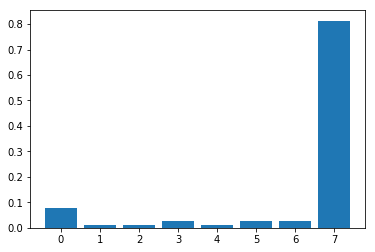

In [24]:
results = qt.sesolve(list_H, H(0).groundstate()[1], times)
amps = np.array([abs(results.states[-1][i])**2 for i in range(8)])
plt.bar([0, 1, 2, 3, 4, 5, 6, 7], amps.flatten())
plt.show()